In [1]:
from Learning import *
from Graphing import *

In [2]:
meta,X,X_rec,Yc,Yr,(meta_labels,X_labels,X_rec_labels,Yc_labels,Yr_labels) = load_ld("db1,2,4,8,20_all") # Load filtered
# meta,X,X_rec,Yc,Yr,(meta_labels,X_labels,X_rec_labels,Yc_labels,Yr_labels) = load_ld("fd2,5,12_all_18390") # Load filtered
# meta,X,X_rec,Yc,Yr,(meta_labels,X_labels,X_rec_labels,Yc_labels,Yr_labels) = load_ld("d2,5,12_all_16k") # Load filtered

In [3]:
meta.shape, X.shape, len(X_labels), X_rec[0][0].shape, len(X_rec_labels), Yc.shape, Yr.shape

((77908, 26), (77908, 9894), 9894, (20, 126), 126, (77908, 13), (77908, 160))

In [4]:
X, X_labels = remove_data_subset(X, X_labels, [l for l in X_labels if "_spell_" in l])
X, X_labels = remove_data_subset(X, X_labels, [l for l in X_labels if "_first_ranked_season" in l])
X, X_labels = remove_data_subset(X, X_labels, [l for l in X_labels if "_last_ranked_season" in l])
X, X_labels = remove_data_subset(X, X_labels, [l for l in X_labels if "_pick_position" in l])
X, X_labels = remove_data_subset(X, X_labels, [l for l in X_labels if "_highest_achieved_season_tier" in l])
X, X_labels = remove_data_subset(X, X_labels, [l for l in X_labels if "_patch__x" in l])
X, X_labels = remove_data_subset(X, X_labels, [l for l in X_labels if "_season__x" in l])
X, X_labels = remove_data_subset(X, X_labels, [l for l in X_labels if "_champion__x" in l])
X.shape, len(X_labels)

((77908, 8244), 8244)

Remove duration (win prediction use case)

In [5]:
X, X_labels = remove_data_subset(X, X_labels, duration_labels)
X.shape

(77908, 8243)

Shuffle data

In [103]:
meta, X, Yc, Yr, X_rec = shuffle_data([meta, X, Yc, Yr], X_rec)

Data normalization/feature scaling

In [40]:
print(Yr.max(), X.max()) # Scale data to between 0 & 1 (remember scaling values)
X_scales, X_scalesdict = scale_data(X, X_labels)
Yr_scales, Yr_scalesdict = scale_data(Yr, Yr_labels)
# unscale_data(X, X_labels, X_scales) # Unscale
# unscale_data(Yr, Yr_labels, Yr_scales)
Yr.max(), X.max()

1.0 1.0


(808610.0, 1538851877124.0)

In [7]:
### For old data: Fix labels
# X_labels = [l.replace("_elo_avg_", "_eloavg_") if "_elo_avg_" in l else l for l in X_labels]
# for i in range(21):
#     X_labels = [l.replace("_" + str(i) + "avg_", "_" + str(i) + "ravg_") if "_" + str(i) + "avg_" in l else l for l in X_labels]
# X_labels = [l.replace("opgg_champion_", "opgg_champion_recent_") if (
#     "opgg_champion_" in l and "opgg_champion_avg" not in l and "opgg_champion_season" not in l) else l for l in X_labels]
# X_labels = [l.replace("_all_total_", "_alltotal_") if (
#     "_all_total_" in l) else l for l in X_labels]

Define experiment models & variables

In [11]:
scorer_str = "multitask_acc"
model_str = "LogisticRegression"
y_label = "blue_win"
# n_test = 3919
n_test = 2000
n_repeat_runs = 1

Y = Yc[:, Yc_labels.index(y_label)].reshape(-1, 1)

# Combinations of features to test
feature_groups_to_test = [['M'], ['G'], ['E'], ['P'], ['R'], ['M', 'E', 'R', 'P', 'G']]

# Powerset of feature groups
# feature_groups_to_test = powerset(label_subsets_dict.keys())[1:]

# Leave-one-group-out
# feature_groups_to_test = [feature_groups_to_test[-1]] + [
#     g for g in feature_groups_to_test if len(g) == len(label_subsets_dict.keys()) - 1]

n_total = 80000
# X_, Y_ = X, Y
meta_, X_, Y_ = meta[:n_total], X[:n_total], Y[:n_total]
X_.shape, Y_.shape, len(feature_groups_to_test)

((77908, 9893), (77908, 1), 6)

Get data subsets (for each feature group combination)

In [13]:
data_subsets = [get_data_subset(X_, X_labels, ss)[0] for ss in feature_groups_to_test]
arglist = sum([[i] * n_repeat_runs for i in range(len(feature_groups_to_test))], [])
len(data_subsets)

6

Train & test models

In [ ]:
results = Parallel(n_jobs=n_parallel_cpu, verbose=5)(delayed(test_model)(
    model_str, scorer_str, meta_, meta_labels, data_subsets[i], Y_, n_test) for i in arglist)
#     model_str, scorer_str, meta, meta_labels, data_subsets[i], Y_, n_test, elo_N=2300) for i in arglist)
len(results)

Summarize and graph results

In [ ]:
results_arr = np.array(results).reshape((len(feature_groups_to_test), n_repeat_runs)) * 100
res_means = np.mean(results_arr, axis=1)
res_stds = np.std(results_arr, axis=1)
feature_group_labels = ['+'.join(g) for g in feature_groups_to_test]
# feature_group_labels = ['All'] + ['-' + [
#     l for l in label_subsets_dict.keys() if l not in g][0] for g in feature_groups_to_test[1:]]
res = list(zip(res_means, res_stds, feature_group_labels))
res.sort()
means, stds, ss_labels = zip(*res)
fig, ax = plt.gcf(), plt.gca()
inds = np.arange(len(feature_group_labels))
p = plt.barh(inds, means, xerr=2 * np.array(stds))
fig.set_size_inches(16, 10)
plt.title("Feature Importances (Logistic Regression, 10,000 training samples, mean over 10 runs $\pm 2\sigma$ error bars)")
plt.ylabel("Feature Group Combinations")
plt.xlabel("Blue Victory % Accuracy")
plt.yticks(inds, ss_labels)
plt.xticks(np.arange(0.50, 1.01, 0.05) * 100)
plt.axis([50, 100, -1, len(ss_labels)])
for i, v in enumerate(means):
    ax.text(v + 2.3, i - 0.2, str(round(v, 2)), color='blue')
plt.grid()
ax.set_axisbelow(True)
legend_str = \
    "M = Match composition (team composition, region, patch, timestamp, etc.)\n" + \
    "E = Elo/skill ratings (Elo rating, league tier, rank, league points, etc.)\n" + \
    "R = Recent matches statistics (Average KDA, winrate, etc. over last 2, 5 & 12 games played by match participants)\n" + \
    "P = Player ranked statistics (Average KDA, winrate etc. overall & for participants' champions, this season & last 1000 games)\n" + \
    "G = Global ranked statistics (Average KDA, winrate etc. for participants' chosen champions, for all players regionally & globally)"
props = dict(boxstyle='round', facecolor='wheat', alpha=0.9)
ax.text(0.01, 0.95, legend_str, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=props)
plt.savefig(graphs_folder + "feature_importances" + '.pdf', format='pdf')
plt.show()

Also plot explained variance vs. number of features

In [124]:
pca = PCA().fit(X_)

Text(0,0.5,'explained_variance_')

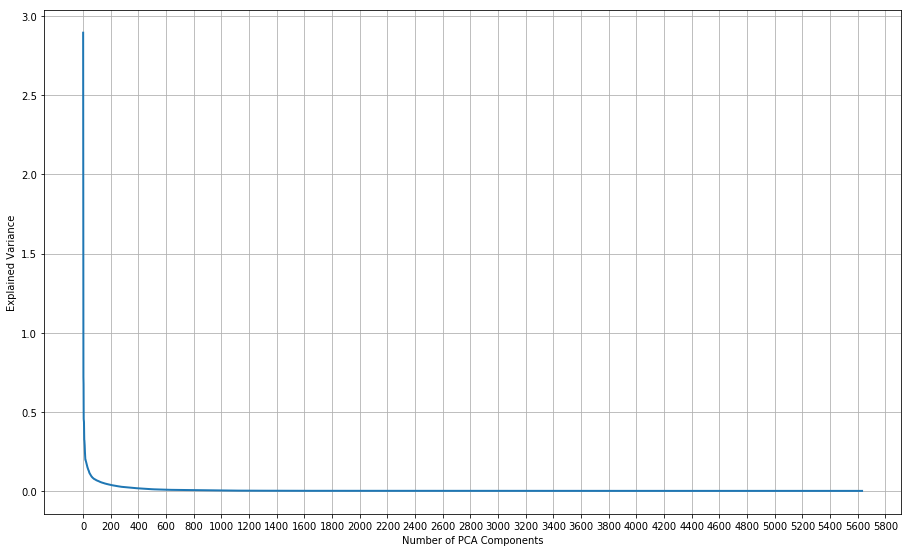

In [132]:
plt.figure(1, figsize=(17, 10))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('Number of PCA Components')
plt.ylabel('Explained Variance')
plt.xticks(np.arange(0, 5801, 200))
ax = plt.gca()
ax.grid()
plt.show()

In [ ]:
plt.figure(1, figsize=(17, 10))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_[:500], linewidth=2)
plt.axis('tight')
plt.xlabel('Number of PCA Components')
plt.ylabel('Explained Variance')
plt.xticks(np.arange(0, 5801, 200))
ax = plt.gca()
ax.grid()
plt.show()

In [104]:
y_label = "blue_win"
Y = Yc[:, Yc_labels.index(y_label)].reshape(-1, 1)

n_train = 65000
n_test = 10000
n_pcal = 1
# n_train = 1000
# n_test = 1000
# n_pcal = 1000

# n_total = 7001
n_total = n_train + n_test + n_pcal
# X_, Y_ = X, Y
meta_, X_, Y_ = meta[:n_total], X[:n_total], Y[:n_total]
Y = Yc[:, Yc_labels.index(y_label)].reshape(-1, 1)
X_train, Y_train, X_pcal, Y_pcal = X_[:n_train], Y_[:n_train], X_[n_train:n_train + n_pcal], Y_[n_train:n_train + n_pcal]
X_test, Y_test = X_[-n_test:], Y_[-n_test:]
meta_train, meta_pcal, meta_test = meta[:n_train], meta[n_train:n_train + n_pcal], meta[-n_test:]
# X_train, Y_train = X[:n_train], Y[:n_train]
# X_test, Y_test = X[-n_test:], Y[-n_test:]
# X_train.shape, X_test.shape
X_train.shape, X_pcal.shape, X_test.shape

((65000, 8243), (1, 8243), (10000, 8243))

In [120]:
synergy_labels = ["_chgg_eloavg_matchup_synergy_adc_win_rate", "_chgg_eloavg_matchup_synergy_support_win_rate",
                  "_chgg_eloavg_matchup_adc_support_win_rate", "_chgg_eloavg_matchup_support_adc_win_rate"]
ch_corrects = []
mu_corrects = []
as_corrects = []
chmu_corrects = []
min_chmu_prob = 0.5
max_chmu_prob = 0.5
min_pred_prob = 0.5
max_pred_prob = 0.5
def apply_th(v, r):
    return 1.0 - v if r[:4] == "red_" else v
# for i in range(25):
for i in range(65000):
    win = Y_[i]
    pred_prob = model.predict_proba(selector.transform(X_[i:i+1]))[0][1]
    pred_prob = 0.46 + (pred_prob * 0.08)
    min_pred_prob = min(pred_prob, min_pred_prob)
    max_pred_prob = max(pred_prob, max_pred_prob)
    avg_ch_wr = np.mean([apply_th(X_[i, new_labels.index(r + "_chgg_eloavg_champion_win_rate")], r) for r in t_roles])
    avg_mu_wr = np.mean([apply_th(X_[i, new_labels.index(r + "_chgg_eloavg_matchup_win_rate")], r) for r in t_roles])
    avg_as_wr = np.mean(sum([[apply_th(X_[i, new_labels.index(c + l)], c) for l in synergy_labels] for c in cols_all], []))
    ch_pred = int(np.round(avg_ch_wr))
    mu_pred = int(np.round(avg_mu_wr))
    as_pred = int(np.round(avg_as_wr))
    chmu_prob = ((avg_ch_wr * 190) + (avg_mu_wr * 10)) / 200
    chmu_pred = int(np.round(chmu_prob))
    min_chmu_prob = min(chmu_prob, min_chmu_prob)
    max_chmu_prob = max(chmu_prob, max_chmu_prob)
    ch_corrects.append(win == ch_pred)
    mu_corrects.append(win == mu_pred)
    as_corrects.append(win == as_pred)
    chmu_corrects.append(win == chmu_pred)
#     print(win, pred_prob, avg_ch_wr, avg_mu_wr)
n = len(ch_corrects)
print(sum(ch_corrects)/n, sum(mu_corrects)/n, sum(chmu_corrects)/n, sum(as_corrects)/n)
print(min_chmu_prob, max_chmu_prob)
print(min_pred_prob, max_pred_prob)

[0.54409231] [0.51829231] [0.54621538] [0.50063077]
0.4712618693171462 0.5295253052454534
0.47036936419852493 0.5297031990176848


In [200]:
class MeanProbPseudo(BaseEstimator, ClassifierMixin):
    
    def __init__(self, X_labels, alpha=None):
        self.alpha = alpha
        ch_labels = [l for l in X_labels if "_chgg_eloavg_champion_win_rate" in l]
        self.ch_blue_lis = [X_labels.index(l) for l in ch_labels if l[:5] == "blue_"]
        self.ch_red_lis = [X_labels.index(l) for l in ch_labels if l[:4] == "red_"]
        if alpha != 0:
            mu_labels = [l for l in X_labels if "_chgg_eloavg_matchup_win_rate" in l]
            self.mu_blue_lis = [X_labels.index(l) for l in mu_labels if l[:5] == "blue_"]
            self.mu_red_lis = [X_labels.index(l) for l in mu_labels if l[:4] == "red_"]
    
    def get_probability(self, X, a):
        res = np.mean(np.hstack([X[:, self.ch_blue_lis], 1.0 - X[:, self.ch_red_lis]]), axis=1, keepdims=True)
        if a != 0:
            res = (res * (1.0 - a)) + (a * \
                np.mean(np.hstack([X[:, self.mu_blue_lis], 1.0 - X[:, self.mu_red_lis]]), axis=1, keepdims=True))
        return np.hstack([1.0 - res, res])
    
    def fit(self, X, Y):
        if self.alpha != 0:
            def get_loss(a):
                a = a / 1
                probs = self.get_probability(X, a)[:, 1]
                preds = np.round(probs).astype(int)
                return 1.0 - (sum(preds == Y) / len(preds)) * 1
            sol = scipy.optimize.minimize(get_loss, [0.3], bounds=[(0, 1)], options={'eps': 0.06, 'gtol': 1e-10})
            print(sol)
            self.alpha = sol.x
        
    def predict_proba(self, X):
        return self.get_probability(X, self.alpha)
    
    def predict(self, X):
        return np.round(self.predict_proba(X)[:, 1])

Test feature selection methods

In [201]:
import scipy
# mkey = "LogisticRegression"
mkey = "SoftmaxRidgeClassifier"
# model = get_model(mkey).estimator
# model = Pipeline(steps=[
#     ("scale", MinMaxScaler()),
#     ("model", model),
# ])
model = MeanProbPseudo(new_labels) # 53.76 for 856 gcs gms
X_train = X_[:n_train]
X_test = X_[-n_test:]
print(X_train.shape)
model.fit(X_train, Y_train.flatten())
preds = model.predict(X_test) # Test accuracy
print(mkey, np.mean(preds == Y_test.flatten()) * 100) # RC = 91.9, robust RC = 91.8, expdec recavgs RC = 93.32!

(65000, 856)
      fun: 0.4549384615384615
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00179487])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 50
      nit: 7
   status: 0
  success: True
        x: array([0.00966612])
SoftmaxRidgeClassifier 53.73


In [207]:
from sklearn.feature_selection import SelectPercentile, SelectKBest, f_classif, mutual_info_classif
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# mkey = "LogisticRegression"
mkey = "SoftmaxRidgeClassifier"
model = get_model(mkey).estimator
# model = Pipeline(steps=[
#     ("scale", MinMaxScaler()),
#     ("model", model),
# ])
# selector = SFS(estimator=model, k_features=(1, 7800), forward=False, floating=True, n_jobs=n_parallel_cpu, verbose=5)
# selector = SelectKBest(k=7500, score_func=mutual_info_classif)
# selector = SelectKBest(k=7900, score_func=f_classif)
# selector = FactorAnalysis(n_components=100)
# selector = SelectKBest(k=100, score_func=f_classif)
selector = SelectPercentile(percentile=75, score_func=f_classif)
X_s = selector.fit_transform(X_, Y_)

X_train = X_s[:n_train]
X_test = X_s[-n_test:]
model.fit(X_train, Y_train.flatten())
preds = model.predict(X_test) # Test accuracy
print(mkey, np.mean(preds == Y_test.flatten()) * 100) # RC = 91.9, robust RC = 91.8, expdec recavgs RC = 93.32!

c:\python36\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SoftmaxRidgeClassifier 54.05


c:\python36\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.563681e-17
  overwrite_a=True).T


Test with match composition or global features only

In [105]:
# new_labels = [l for l in X_labels if (l[:l.index("__x")] if "__x" in l else l) in match_composition_labels]
# new_labels += global_statistics_labels
new_labels = global_statistics_labels
# new_labels = [l for l in global_statistics_labels if "chgg" in l]
# new_labels = [l for l in X_labels if "_champion__x" not in l]
# new_labels = ls
# new_labels = [l for l in X_labels if (l[:l.index("__x")] if "__x" in l else l) in match_composition_labels] + \
#     [l if "_eloavg_" not in l else l.replace("_eloavg_", "_elo_avg_") for l in global_statistics_labels]
# new_labels = [l for l in X_labels if l not in new_labels]
new_label_is = [X_labels.index(l) for l in new_labels]
len(new_labels)

856

In [17]:
globals_champs_ls = [l for l in global_statistics_labels if "_matchup_" not in l and "_synergy_" not in l and "_adc_support_" \
                     not in l and "_support_adc_" not in l]
globals_champs_matchup_ls = [l for l in global_statistics_labels if l not in globals_champs_ls]
globals_champs_1v1_matchup_ls = [l for l in globals_champs_matchup_ls if "_synergy_" not in l and "_adc_support_" not in l and \
                                 "_support_adc_" not in l]
len(globals_champs_ls), len(globals_champs_matchup_ls), len(globals_champs_1v1_matchup_ls)

(640, 216, 120)

In [44]:
# new_label_is = [X_labels.index(l) for l in globals_champs_ls]
new_label_is = [X_labels.index(l) for l in globals_champs_matchup_ls]
# new_label_is = [X_labels.index(l) for l in globals_champs_1v1_matchup_ls]

In [106]:
X_ = X_[:, new_label_is]
X_.shape

(75001, 856)

In [65]:
elo_N = 2400
# X_train_is = np.nonzero(meta_train[:, meta_labels.index("elo")] > elo_N)[0]
# X_test_is = np.nonzero(meta_test[:, meta_labels.index("elo")] > elo_N)[0]
X_train_is = np.asarray(range(len(X_train)))
X_test_is = np.asarray(range(len(X_test)))
print(X_train_is.shape, X_test_is.shape)

(11000,) (918,)


In [66]:
new_X_train = X_train[:, new_label_is]
new_X_test = X_test[:, new_label_is]
# new_X_train = new_X_train[X_train_is, :]
new_X_test = new_X_test[X_test_is, :]
# new_Y_train = Y_train[X_train_is, :]
new_Y_train = Y_train
new_Y_test = Y_test[X_test_is, :]
mkey = "LogisticRegression"
# mkey = "SoftmaxRidgeClassifier"
# mkey = "AdaBoostClassifier"
# mkey = "MLPClassifier"
# model = get_model(mkey)
model = get_model(mkey).estimator
# model = Pipeline(steps=[
# #     ("scale", MinMaxScaler()),
#     ("pca", PCA(n_components=15)),
# #     ("pca", FactorAnalysis(n_components=200)),
#     ("model", model),
# ])
# model.fit(new_X_train, Y_train.flatten())
print(new_X_train.shape)
model.fit(new_X_train, new_Y_train.flatten())
# model.fit(new_X_train, Y_train)
preds = model.predict(new_X_test) # Test accuracy
# print(mkey, np.mean(preds == Y_test.flatten()) * 100) # RC = 91.9, robust RC = 91.8, expdec recavgs RC = 93.32!
print(mkey, np.mean(preds == new_Y_test.flatten()) * 100) # RC = 91.9, robust RC = 91.8, expdec recavgs RC = 93.32!

(11000, 676)
LogisticRegression 53.26797385620915


In [56]:
# Print global champion and matchup stats (for verification)
done = 0
for i in range(4,len(X)):
    patch = meta[i, meta_labels.index("game_version")]
    if patch < 8.19:
        continue
    done += 1
    c_names = {role: champion_names[ordered_cids[np.nonzero(X[i, \
        [X_labels.index(role + '_champion__x' + str(n)) for n in range(len(ordered_cids))]])[0][0]]] for role in t_roles}
    elos = {role: leag_tiers[X[i, [X_labels.index(l) for l in X_labels if "_int_tier" in l]].astype(int)[0]] for role in t_roles}
    for l in global_statistics_labels:
        l_list = l.split('_')
        role = '_'.join(l_list[:2])
        if role in t_roles:
            print(patch, elos[role], c_names[role], l, X[i, X_labels.index(l)])
        else:
            print(l, X[i, X_labels.index(l)])
    if done > 5: break

8.192465109 silver Tryndamere blue_top_opgg_eloavg_champion_month_games 3832.0
8.192465109 silver Tryndamere blue_top_opgg_eloavg_champion_month_games_fraction 0.008203933692005661
8.192465109 silver Tryndamere blue_top_opgg_eloavg_champion_month_win_rate 48.59
8.192465109 silver Tryndamere blue_top_opgg_eloavg_champion_month_kda_ratio 1.78
8.192465109 silver Tryndamere blue_top_opgg_eloavg_champion_month_gold 12016.0
8.192465109 silver Tryndamere blue_top_opgg_eloavg_champion_month_creep_score 161.5
8.192465109 silver Tryndamere blue_top_opgg_eloavg_champion_week_games 439.0
8.192465109 silver Tryndamere blue_top_opgg_eloavg_champion_week_games_fraction 0.006947191846940229
8.192465109 silver Tryndamere blue_top_opgg_eloavg_champion_week_win_rate 49.2
8.192465109 silver Tryndamere blue_top_opgg_eloavg_champion_week_kda_ratio 1.83
8.192465109 silver Tryndamere blue_top_opgg_eloavg_champion_week_gold 12132.0
8.192465109 silver Tryndamere blue_top_opgg_eloavg_champion_week_creep_score 16

8.192465109 silver Evelynn red_jungle_chgg_eloavg_champion_duration_25_to_30_games 3422.0
8.192465109 silver Evelynn red_jungle_chgg_eloavg_champion_duration_30_to_35_games 3561.0
8.192465109 silver Evelynn red_jungle_chgg_eloavg_champion_duration_35_to_40_games 2172.0
8.192465109 silver Evelynn red_jungle_chgg_eloavg_champion_duration_40_plus_games 1681.0
8.192465109 silver Evelynn red_jungle_chgg_eloavg_champion_duration_0_to_15_games_fraction 0.03901842158928693
8.192465109 silver Evelynn red_jungle_chgg_eloavg_champion_duration_15_to_20_games_fraction 0.05689620012235742
8.192465109 silver Evelynn red_jungle_chgg_eloavg_champion_duration_20_to_25_games_fraction 0.16749371218815853
8.192465109 silver Evelynn red_jungle_chgg_eloavg_champion_duration_25_to_30_games_fraction 0.232615049962613
8.192465109 silver Evelynn red_jungle_chgg_eloavg_champion_duration_30_to_35_games_fraction 0.24206376181088982
8.192465109 silver Evelynn red_jungle_chgg_eloavg_champion_duration_35_to_40_games_f

8.192465109 silver Kha'Zix blue_jungle_chgg_eloavg_champion_largest_kill_spree 11.0
8.192465109 silver Kha'Zix blue_jungle_chgg_eloavg_champion_creep_score 38.743567488870845
8.192465109 silver Kha'Zix blue_jungle_chgg_eloavg_champion_gold 11740.901027521908
8.192465109 silver Kha'Zix blue_jungle_chgg_eloavg_champion_total_damage_taken 28801.94467620461
8.192465109 silver Kha'Zix blue_jungle_chgg_eloavg_champion_total_heal 11922.16902315424
8.192465109 silver Kha'Zix blue_jungle_chgg_eloavg_champion_wards_placed 8.178486435030937
8.192465109 silver Kha'Zix blue_jungle_chgg_eloavg_champion_wards_killed 3.6624576532183553
8.192465109 silver Kha'Zix blue_jungle_chgg_eloavg_champion_total_damage 17663.491754626648
8.192465109 silver Kha'Zix blue_jungle_chgg_eloavg_champion_total_magic_damage 1282.3264831872777
8.192465109 silver Kha'Zix blue_jungle_chgg_eloavg_champion_total_physical_damage 15546.301453089565
8.192465109 silver Kha'Zix blue_jungle_chgg_eloavg_champion_total_true_damage 834

8.192465109 silver Xerath red_middle_chgg_eloavg_matchup_creep_score 184.53883495145632
8.192465109 silver Xerath red_middle_chgg_eloavg_matchup_total_damage_dealt_to_champions 27808.300970873788
8.192465109 silver Xerath red_middle_chgg_eloavg_matchup_kill_sprees 1.6213592233009708
8.192465109 silver Xerath red_middle_chgg_eloavg_matchup_jungle_creep_score_team 8.033980582524272
8.192465109 silver Xerath red_middle_chgg_eloavg_matchup_weighed_score 65105.54902912621
8.192465109 silver Alistar red_support_opgg_eloavg_champion_month_games 65514.0
8.192465109 silver Alistar red_support_opgg_eloavg_champion_month_games_fraction 0.0074815641692527746
8.192465109 silver Alistar red_support_opgg_eloavg_champion_month_win_rate 49.3
8.192465109 silver Alistar red_support_opgg_eloavg_champion_month_kda_ratio 2.53
8.192465109 silver Alistar red_support_opgg_eloavg_champion_month_gold 7986.0
8.192465109 silver Alistar red_support_opgg_eloavg_champion_month_creep_score 41.99
8.192465109 silver Ali

8.192465109 silver Maokai blue_middle_chgg_eloavg_matchup_total_damage_dealt_to_champions 14549.725
8.192465109 silver Maokai blue_middle_chgg_eloavg_matchup_kill_sprees 0.7083333333333334
8.192465109 silver Maokai blue_middle_chgg_eloavg_matchup_jungle_creep_score_team 1.7
8.192465109 silver Maokai blue_middle_chgg_eloavg_matchup_weighed_score 36681.77875
8.192465109 silver Ziggs blue_support_opgg_eloavg_champion_month_games 12539.0
8.192465109 silver Ziggs blue_support_opgg_eloavg_champion_month_games_fraction 0.0
8.192465109 silver Ziggs blue_support_opgg_eloavg_champion_month_win_rate 49.1
8.192465109 silver Ziggs blue_support_opgg_eloavg_champion_month_kda_ratio 2.19
8.192465109 silver Ziggs blue_support_opgg_eloavg_champion_month_gold 11402.0
8.192465109 silver Ziggs blue_support_opgg_eloavg_champion_month_creep_score 152.58
8.192465109 silver Ziggs blue_support_opgg_eloavg_champion_week_games 2127.0
8.192465109 silver Ziggs blue_support_opgg_eloavg_champion_week_games_fraction 0

8.192465109 silver Ezreal red_adc_chgg_eloavg_champion_play_rate 0.09293019501429761
8.192465109 silver Ezreal red_adc_chgg_eloavg_champion_percent_role_played 0.7343350135711516
8.192465109 silver Ezreal red_adc_chgg_eloavg_champion_kills 6.219499960398131
8.192465109 silver Ezreal red_adc_chgg_eloavg_champion_deaths 5.676215117353539
8.192465109 silver Ezreal red_adc_chgg_eloavg_champion_assists 8.951210497135465
8.192465109 silver Ezreal red_adc_chgg_eloavg_champion_kda_ratio 2.6726806760993123
8.192465109 silver Ezreal red_adc_chgg_eloavg_champion_kill_sprees 1.4577184043086833
8.192465109 silver Ezreal red_adc_chgg_eloavg_champion_largest_kill_spree 8.0
8.192465109 silver Ezreal red_adc_chgg_eloavg_champion_creep_score 184.3030599044275
8.192465109 silver Ezreal red_adc_chgg_eloavg_champion_gold 12640.690418987777
8.192465109 silver Ezreal red_adc_chgg_eloavg_champion_total_damage_taken 18184.77886316234
8.192465109 silver Ezreal red_adc_chgg_eloavg_champion_total_heal 2526.993848

8.192465109 platinum Kai'Sa blue_adc_opgg_eloavg_champion_month_win_rate 50.82
8.192465109 platinum Kai'Sa blue_adc_opgg_eloavg_champion_month_kda_ratio 2.4
8.192465109 platinum Kai'Sa blue_adc_opgg_eloavg_champion_month_gold 13187.0
8.192465109 platinum Kai'Sa blue_adc_opgg_eloavg_champion_month_creep_score 201.19
8.192465109 platinum Kai'Sa blue_adc_opgg_eloavg_champion_week_games 12162.0
8.192465109 platinum Kai'Sa blue_adc_opgg_eloavg_champion_week_games_fraction 0.02208361705025194
8.192465109 platinum Kai'Sa blue_adc_opgg_eloavg_champion_week_win_rate 50.58
8.192465109 platinum Kai'Sa blue_adc_opgg_eloavg_champion_week_kda_ratio 2.37
8.192465109 platinum Kai'Sa blue_adc_opgg_eloavg_champion_week_gold 13169.0
8.192465109 platinum Kai'Sa blue_adc_opgg_eloavg_champion_week_creep_score 199.97
8.192465109 platinum Kai'Sa blue_adc_opgg_eloavg_champion_today_games 2159.0
8.192465109 platinum Kai'Sa blue_adc_opgg_eloavg_champion_today_games_fraction 0.024109705301008387
8.192465109 plati

8.192465109 gold Poppy blue_top_opgg_eloavg_champion_week_games_fraction 0.0
8.192465109 gold Poppy blue_top_opgg_eloavg_champion_week_win_rate 48.27
8.192465109 gold Poppy blue_top_opgg_eloavg_champion_week_kda_ratio 2.4
8.192465109 gold Poppy blue_top_opgg_eloavg_champion_week_gold 10616.0
8.192465109 gold Poppy blue_top_opgg_eloavg_champion_week_creep_score 142.4
8.192465109 gold Poppy blue_top_opgg_eloavg_champion_today_games 2487.0
8.192465109 gold Poppy blue_top_opgg_eloavg_champion_today_games_fraction 0.0
8.192465109 gold Poppy blue_top_opgg_eloavg_champion_today_win_rate 48.81
8.192465109 gold Poppy blue_top_opgg_eloavg_champion_today_kda_ratio 2.42
8.192465109 gold Poppy blue_top_opgg_eloavg_champion_today_gold 10663.0
8.192465109 gold Poppy blue_top_opgg_eloavg_champion_today_creep_score 144.33
8.192465109 gold Poppy blue_top_chgg_eloavg_champion_games 13051.0
8.192465109 gold Poppy blue_top_chgg_eloavg_champion_win_rate 0.5039460577733507
8.192465109 gold Poppy blue_top_chg

8.192465109 gold Nidalee red_jungle_chgg_eloavg_champion_duration_15_to_20_games_fraction 0.07568553737284388
8.192465109 gold Nidalee red_jungle_chgg_eloavg_champion_duration_20_to_25_games_fraction 0.2005749668288368
8.192465109 gold Nidalee red_jungle_chgg_eloavg_champion_duration_25_to_30_games_fraction 0.2599513489606369
8.192465109 gold Nidalee red_jungle_chgg_eloavg_champion_duration_30_to_35_games_fraction 0.23739495798319327
8.192465109 gold Nidalee red_jungle_chgg_eloavg_champion_duration_35_to_40_games_fraction 0.12864882795223354
8.192465109 gold Nidalee red_jungle_chgg_eloavg_champion_duration_40_plus_games_fraction 0.06855373728438743
8.192465109 gold Nidalee red_jungle_chgg_eloavg_champion_duration_0_to_15_win_rate 0.509469696969697
8.192465109 gold Nidalee red_jungle_chgg_eloavg_champion_duration_15_to_20_win_rate 0.504017531044558
8.192465109 gold Nidalee red_jungle_chgg_eloavg_champion_duration_20_to_25_win_rate 0.49448732083792724
8.192465109 gold Nidalee red_jungle_

8.192465109 silver Lux blue_middle_chgg_eloavg_champion_duration_0_to_15_win_rate 0.0
8.192465109 silver Lux blue_middle_chgg_eloavg_champion_duration_15_to_20_win_rate 0.0
8.192465109 silver Lux blue_middle_chgg_eloavg_champion_duration_20_to_25_win_rate 0.5536704730831974
8.192465109 silver Lux blue_middle_chgg_eloavg_champion_duration_25_to_30_win_rate 0.5203687821612349
8.192465109 silver Lux blue_middle_chgg_eloavg_champion_duration_30_to_35_win_rate 0.5158140522182127
8.192465109 silver Lux blue_middle_chgg_eloavg_champion_duration_35_to_40_win_rate 0.5157299399080947
8.192465109 silver Lux blue_middle_chgg_eloavg_champion_duration_40_plus_win_rate 0.4783689706613625
8.192465109 silver Lux blue_middle_chgg_eloavg_matchup_games 0.0
8.192465109 silver Lux blue_middle_chgg_eloavg_matchup_wins 60.6
8.192465109 silver Lux blue_middle_chgg_eloavg_matchup_win_rate 0.5488163265306122
8.192465109 silver Lux blue_middle_chgg_eloavg_matchup_kills 6.23934693877551
8.192465109 silver Lux blue